# Recharge and Particles - Self Check Example with a loop

## Model Description 
This is a steady state box model with recharge

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is no flow (i.e. a closed basin) 
 - Left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 5E-6 m/d uniformly across the domain
 
### Wells
 - one well located in row=12, col=12 pumping at a rage of -10 m3/day

## 1. Setup the environment

In [3]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Setup the Inputs


### Discretization (DIS package)

For more details on DIS package inputs refer to : http://modflowpy.github.io/flopydoc/mfdis.html

In [4]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x diretion 
dy= 100 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 10.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


### Constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: http://modflowpy.github.io/flopydoc/mfbas.html

In [5]:
#Define cell activity (IBOUND)
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#set constand head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#Define Starting Heads
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 7    #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

### Layer Properties  (LPF Package)

For more details on LPF package see: http://modflowpy.github.io/flopydoc/mflpf.html

In [8]:
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

### Outputs by stress period (OC Package)
For more details on OC Package: http://modflowpy.github.io/flopydoc/mfoc.html

In [10]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


### Recharge (RCH Package)
For more details on the RCH package see: http://modflowpy.github.io/flopydoc/mfrch.html and https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?rch.htm

In [30]:
#Make recharge scenarios                                  
##Recharge:
nscen = 2                            #number of different recharge scenarios
rech = np.zeros((nscen,nrow,ncol))   #define an array of zeros of dim (nscen,nrow,ncol)
rech[0,:,:] = 5e-6                   #define uniform recharge flux (m/day) for 1st scenario
rech[1,:,20:25] = 2.4e-5             #define zonal recharge flux (m/day) for 2nd scenario


### Well Package (WEL)

In [31]:
pumping_rate = -10 #in m^3/d, negative for pumping/positive for injection
well_loc=(0,12,12)
well_1 = [i for i in well_loc] + [-10]
print("Well 1 [layer, row, column, flux]: \n", well_1)

wel_spd = {0: [well_1]}
print("Well Stress Period Data: \n", wel_spd)

Well 1 [layer, row, column, flux]: 
 [0, 12, 12, -10]
Well Stress Period Data: 
 {0: [[0, 12, 12, -10]]}


## 3. Build packages, write inputs and run within a lop

In [32]:
#For two different recharge scenarios:
moddir="/Applications/MODFLOW/mf2005"
moddirmp="/Applications/MODFLOW/mp7"

for scenario in [0,1]:
    print(scenario)
    #create model object 
    modelname = "RechargeModel_Scen"+str(scenario)
    mpname=modelname +'_mp'
    print(modelname)
    print(mpname)

    m = flopy.modflow.Modflow(modelname, exe_name = moddir)
  
    #Create objects for each package (see GHW1 notebook for details):
    #create flopy discretization object, length and time are meters (2) and days (4)
    #DIS (Discretization): creates model grid 
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)  #BAS (Basic): assigns head boundaries
    #LPF (Layer Property Flow): assigns flow props between cells
    lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
    
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True) #OC (Output Control): Decides what outputs to save
    pcg = flopy.modflow.ModflowPcg(model=m) #PCG (Preconditioned Conjugate Gradient)
    rch = flopy.modflow.mfrch.ModflowRch(m, rech=rech[scenario,:,:])       #RCH (Recharge)
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    #Write MODFLOW input files:
    m.write_input()
    
    #Run MODFLOW:
    success, buff = m.run_model()
    
    
    #run modpath 
    mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='forward', flowmodel=m,  
                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
                                        exe_name=moddirmp)


    # write modpath datasets
    mp.write_input()

    # run modpath
    mp.run_model()



0
RechargeModel_Scen0
RechargeModel_Scen0_mp
FloPy is using the following  executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: RechargeModel_Scen0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/02/20 12:16:10

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/02/20 12:16:10
 Elapsed run time:  0.005 Seconds

  Normal termination of simulation
FloPy is using the following  executable to run the model: /Applications/MODFLOW/mp7

MODPATH Version 7.2.001   
Program compiled Dec 31 2019 16:53:36 with GFORTRAN compiler (ver. 8.1.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                   

## 6. Plotting and analysis

### Read in particle files

In [35]:
#load in the flow path file
scenario=0
print(scenario)
modelname = "RechargeModel_Scen"+str(scenario)
mpname=modelname +'_mp'

fpth = os.path.join(mpname + '.mppth')
print(fpth)
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
print(fpth)
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is the partlces that end in the well 
nodewell = m.dis.get_node([well_loc])
print(nodewell)
pwell = p.get_destination_pathline_data(dest_cells=nodewell)
ewell= e.get_destination_endpoint_data(dest_cells=nodewell)

0
RechargeModel_Scen0_mp.mppth
RechargeModel_Scen0_mp.mpend
[312]


### Plot particle pathlines

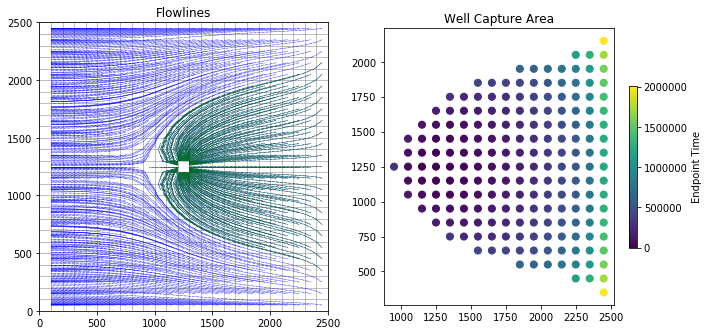

In [36]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell, layer='all', color='green', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
#mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
#mm.plot_endpoint(eall, direction='starting')
#mm.ax.legend();

ax = axes[1]
ax.set_aspect('equal')
ax.set_title('Well Capture Area')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_endpoint(ewell, direction='starting', colorbar=True, shrink=0.5);
#mm.plot_grid(lw=0.5)
#mm.plot_pathline(prb, layer='all', color='green', lw=0.5, linestyle=':', label='captured by rivers')

plt.tight_layout();

### Read in MODFLOW outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

In [26]:
#heads
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)
#print("Flow through Right Face of Grid Cells m^3/d \n", frf,
#     "\n Flow through Front Face of Grid Cells m^3/d \n", fff)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

### Plot head transect

Head Gradient -1.9073486328125e-10 m/m


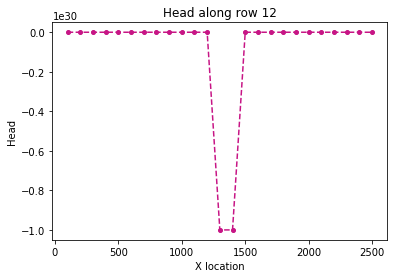

In [27]:
fig4 = plt.figure() 
x=np.arange(100,2600,100) 
y=head[0,5,:]
plt.plot(x,head[0,12,:],marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.title('Scatter plot pythonspot.com')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 12")
#plt.axvline(x=1200)
plt.savefig('Head_Transect.png')

hgrad=(head[0,5,0]-head[0,5,-1])/Lx
print("Head Gradient", hgrad, "m/m") 


### 3D head surface

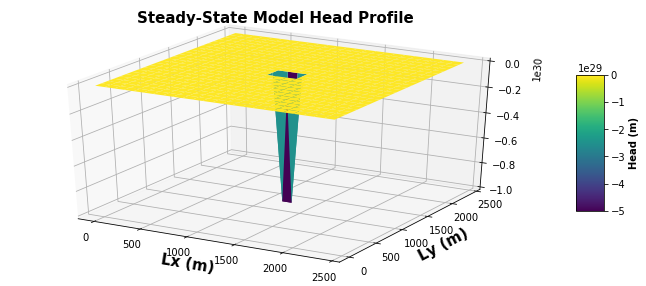

In [28]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
#plt.show(surf)
plt.savefig('BoxModel_Surface1.png') 

###  Head Contours

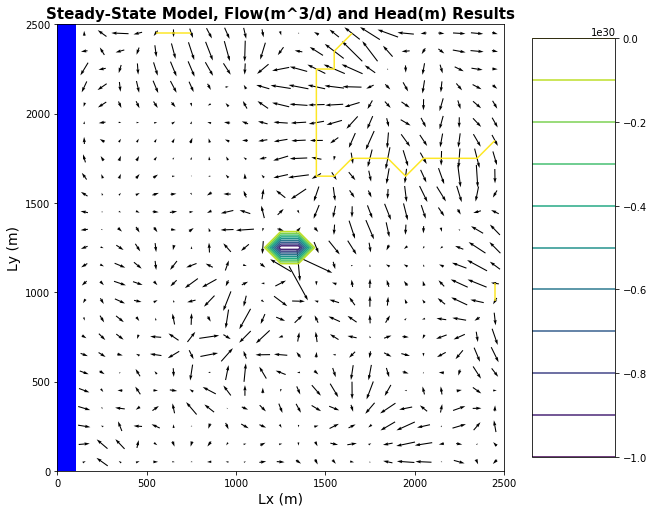

In [29]:
#plot results
fig3=plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
plt.savefig('BoxModel_vectors.png')   